In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe
from pandas.api.types import CategoricalDtype

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Setup and configuration

In [3]:
# Font veranderen. 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [4]:
base_path = './processed_data/load_testing_results'
scenarios = ['1_register_and_create_transaction', '2_login_and_get_transactions']

# Human readable titles for the scenarios.  
scenario_desriptions = {
    '1_register_and_create_transaction': 'Registreren van gebruiker en Transactie aanmaken',
    '2_login_and_get_transactions': ' inloggen en Transactie ophalen',
}

## Mean and standard deviation

Calculate mean and standard deviation.

In [5]:
for scenario in scenarios: 
    koa = pd.read_csv(filepath_or_buffer=f'{base_path}/koa/{scenario}.csv', delimiter=',', header=0, index_col=0)
    hono = pd.read_csv(filepath_or_buffer=f'{base_path}/hono/{scenario}.csv', delimiter=',', header=0, index_col=0)
    nest = pd.read_csv(filepath_or_buffer=f'{base_path}/nest/{scenario}.csv', delimiter=',', header=0, index_col=0)

    koa = koa[koa['count'] >= 30]
    hono = hono[hono['count'] >= 30]
    nest = nest[nest['count'] >= 30]

    koa_mean = koa['mean'].mean()
    koa_std = koa['mean'].std()

    hono_mean = hono['mean'].mean()
    hono_std = hono['mean'].std()

    nest_mean = nest['mean'].mean()
    nest_std = nest['mean'].std()

    print(scenario)
    print(f'Koa: mean={koa_mean} std={koa_std}')
    print(f'Hono: mean={hono_mean} std={hono_std}')
    print(f'Nest: mean={nest_mean} std={nest_std}')
    print()


1_register_and_create_transaction
Koa: mean=13.5 std=0.44721359549995776
Hono: mean=12.733333333333333 std=0.39619401430321616
Nest: mean=14.218181818181819 std=0.4578606377887964

2_login_and_get_transactions
Koa: mean=30.950000000000003 std=1.5512458336329666
Hono: mean=30.79166666666667 std=1.0933337952696727
Nest: mean=30.50909090909091 std=2.9770638372243705



## Visualization

Grouped boxplot, grouped density plot and histogram.

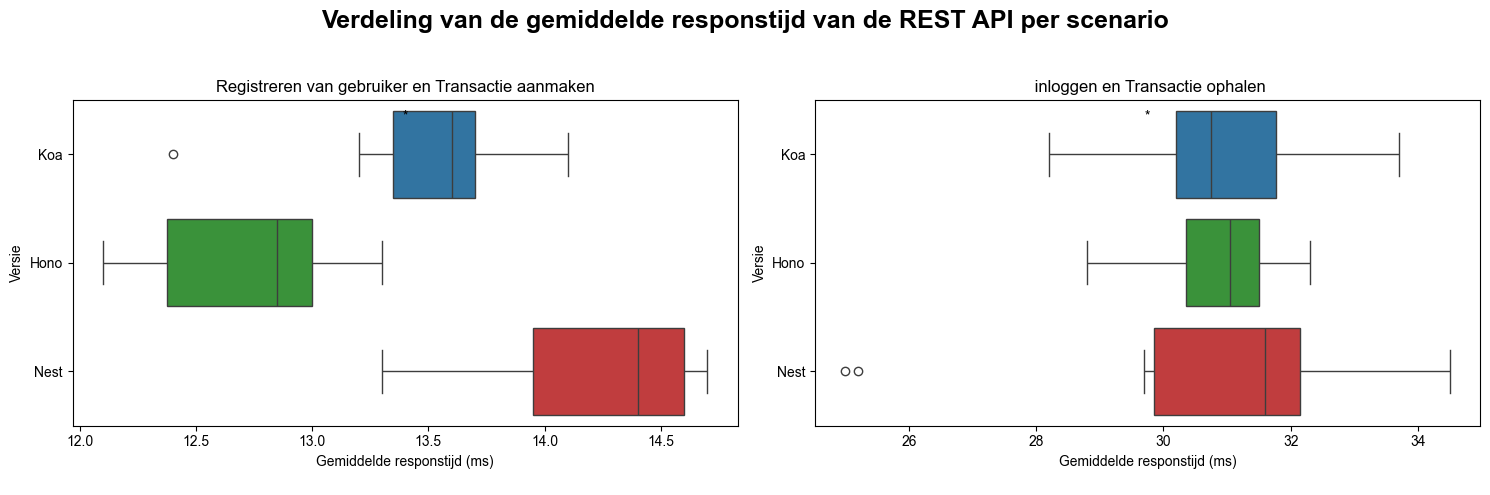

In [6]:
import textwrap

custom_palette = {
    'Koa': '#1f77b4',    # blauw
    'Hono': '#2ca02c',   # groen
    'Nest': '#d62728'    # rood
}

# Grouped boxplot.
figure, axes = plt.subplots(len(scenarios)//2, 2, figsize=(15, 5*len(scenarios)//2))
axes = axes.ravel()

title = 'Verdeling van de gemiddelde responstijd van de REST API per scenario'
wrapped_title = textwrap.fill(title, width=100)

figure.suptitle(f'{wrapped_title}\n', fontweight='bold', fontsize=18)

for ax, scenario in zip(axes, scenarios):
    koa = pd.read_csv(filepath_or_buffer=f'{base_path}/koa/{scenario}.csv', delimiter=',', header=0, index_col=0)
    hono = pd.read_csv(filepath_or_buffer=f'{base_path}/hono/{scenario}.csv', delimiter=',', header=0, index_col=0)
    nest = pd.read_csv(filepath_or_buffer=f'{base_path}/nest/{scenario}.csv', delimiter=',', header=0, index_col=0)

    koa = koa[koa['count'] >= 30]
    hono = hono[hono['count'] >= 30]
    nest = nest[nest['count'] >= 30]


    koa['source'] = 'Koa'
    hono['source'] = 'Hono'
    nest['source'] = 'Nest'

    data = pd.concat([koa, hono, nest])

    sns.boxplot(
        data=data,
        x='mean',
        y='source',
        hue='source',
        ax=ax,
        palette=custom_palette,
        legend=False
        )

    ax.set_title(scenario_desriptions[scenario])
    ax.text(0.5, 0.95, '*', ha='center', va='center', transform=ax.transAxes) # Significance indicator.

    ax.set_xlabel('Gemiddelde responstijd (ms)\n')
    ax.set_ylabel('Versie')

plt.tight_layout()
plt.show()

figure.savefig('gemiddelde_responstijd_api_voor_en_na.png', bbox_inches='tight', dpi=300)

## T-test for two paired samples

One qualitative (before and after) and one quantitative (response time in ms) variable.

#### Testprocedure

**Step 1.** Formulate the hypotheses:

- $x$: nest 
- $y$: hono

- $H_0$: $\overline{x - y} = 0$ Er is geen verschil in prestaties tussen Nest en Hono.
- $H_1$: $\overline{x - y} < 0$ Nest presteert beter dan Hono. 


**Step 2.** Choose a significance level, e.g. $\alpha = 5\%$

In [7]:
alpha = .05

**Step 3 and 4.** Calculate the test statistic $\overline{x - y}$ and calculate the $p$-value:

- $x$ = Mean response time (in ms) of the nest-project.
- $y$ = Mean response time (in ms) of hono-project.

In [ ]:
def equalize_length(data1, data2):
    min_length = min(len(data1), len(data2))
    return data1.iloc[-min_length:], data2.iloc[-min_length:]

In [9]:
for scenario in scenarios:
    nest = pd.read_csv(filepath_or_buffer=f'{base_path}/nest/{scenario}.csv', delimiter=',', header=0, index_col=0)
    hono = pd.read_csv(filepath_or_buffer=f'{base_path}/hono/{scenario}.csv', delimiter=',', header=0, index_col=0)

    nest = nest[nest['count'] >= 30]
    hono = hono[hono['count'] >= 30]

    nest, hono = equalize_length(nest['mean'], hono['mean'])

    statistic, p = stats.ttest_rel(a=nest, b=hono, alternative='less')
    # before is less than after. 

    print(f'Scenario: {scenario}')
    print(f'Statistic (x - y):   %.4f' % statistic)
    print(f'P-value:             {p}')
    if (p > alpha):
        print('p-value = %.4f (%.4f%%) > alpha = %.4f (%.4f%%): Do not reject H0' % (p, p*100, alpha, alpha*100))
    else:  
        print('p-value = %.4f (%.4f%%) < alpha = %.4f (%.4f%%): Reject H0' % (p, p*100, alpha, alpha*100))
    print()


Scenario: 1_register_and_create_transaction
Statistic (x - y):   11.1018
P-value:             0.9999996974505898
p-value = 1.0000 (100.0000%) > alpha = 0.0500 (5.0000%): Do not reject H0

Scenario: 2_login_and_get_transactions
Statistic (x - y):   -0.1580
P-value:             0.4387962223892591
p-value = 0.4388 (43.8796%) > alpha = 0.0500 (5.0000%): Do not reject H0

